<a href="https://colab.research.google.com/github/AkindeKadjo/Small-projects/blob/main/request_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using LSTM to predict Service Request Loads

#Library import and data loading

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense
import tensorflow as tf

In [10]:
df = pd.read_excel('/content/drive/MyDrive/LinkedIn learning/RNN/requests.xlsx')
df.head()

,Requests
0,100
1,113
2,162
3,186
4,228


#Visualisation

This is a time series data that may have cyclic or seasonal patterns

Text(0.5, 1.0, 'Overall')

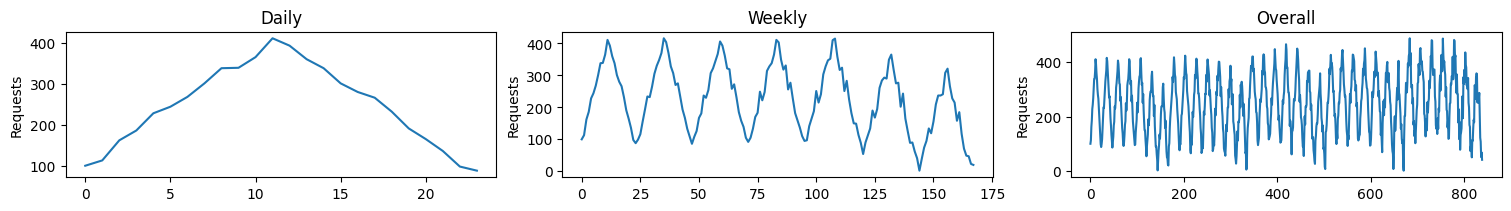

In [14]:
fig, axes = plt.subplots(1,3, figsize = (15,2), constrained_layout=True)
sns.lineplot(ax=axes[0],x=range(24),y=df['Requests'][:24])
axes[0].set_title('Daily')
sns.lineplot(ax=axes[1],x=range(168),y=df['Requests'][:168])
axes[1].set_title('Weekly')
sns.lineplot(ax=axes[2],x=range(len(df)),y=df['Requests'][:(len(df))])
axes[2].set_title('Overall')

#Data Prep

In [19]:
#The Data will be scaled before any processsing is done
scaler = StandardScaler()
scaled_requests=scaler.fit_transform(df)

#Training set will be the first 4 weeks
train_requests = scaled_requests[0:(24*7*4),:]

#Since the overall repeat is weekly, our lookback here is weekly
lookback = 24*7
#Also for prediction, the test training set would need a week worth of lookback for prediction
test_requests = scaled_requests[(24*7*4-24*7):,:]

print("\n Shaped of Train, Test : ",
      train_requests.shape, test_requests.shape)


 Shaped of Train, Test :  (672, 1) (336, 1)


In [21]:
##Creating a lookback function
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

In [22]:
#Prepare RNN Dataset

#Create X and Y for training and testing
train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)
test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#LSTM model with Keras

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score
##I'm creating a function that will output the metrics for my model prediction evaluation
#creating a data frame output of the metrics
def res_regression(model,xtest,ytest,xtrain,ytrain, label='X Regression'):
  """Output regression metrics for both the test and the train data"""
 
  ## Get Predictions
  test_pred = model.predict(xtest)
  train_pred = model.predict(xtrain)
  ## Creating a header
  print('---'*20)
  print(f"[i] REPORT FOR: {label}")
  print('---'*20)
  #test metrics
  mse_test = mean_squared_error(ytest, test_pred)
  rmse_test = np.sqrt(mse_test).round(0)
  r2_test = r2_score(ytest, test_pred).round(4)
  res_df_test = pd.DataFrame([rmse_test,r2_test], columns=['Test data'],index=['RMSE','R2'])
  #train metrics
  mse_train = mean_squared_error(ytrain, train_pred)
  rmse_train = np.sqrt(mse_train).round(0)
  r2_train = r2_score(ytrain, train_pred).round(4)
  res_df_train = pd.DataFrame([rmse_train,r2_train],columns=['Training data'],index=['RMSE','R2'])
  res_df = pd.concat([res_df_test, res_df_train],axis = 1)
  return res_df

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               435200    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 435,457
Trainable params: 435,457
Non-trainable params: 0
_________________________________________________________________
16/16 [==============================] - 0s 3ms/step
------------------------------------------------------------
[i] REPORT FOR: LSTM
------------------------------------------------------------
      Test data  Training data
RMSE     0.0000         0.0000
R2       0.8731         0.9679


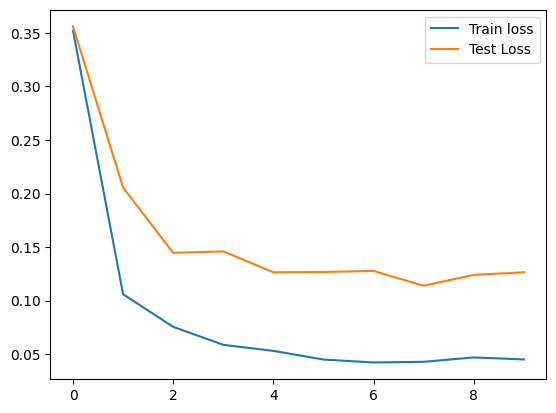

In [33]:
tf.random.set_seed(3)

#Create a Keras Model
ts_model=Sequential()
#layer = tf.keras.layers.Dropout(.2, input_shape=(1,lookback))
#Add LSTM
ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(tf.keras.layers.Dropout(rate=0.2))
ts_model.add(Dense(1))

#layer = tf.keras.layers.Dropout(.2, input_shape=(1,lookback))
#ts_model["DROPOUT_RATE"] = 0.2

#Compile with Adam Optimizer. Optimize for minimum mean square error
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
ts_model.summary()

# Fit our model
history = ts_model.fit(train_req_x, train_req_y, validation_data = (test_req_x, test_req_y), 
                    epochs=10, verbose=0 )

# Evaluate the linear regression model and print
print(res_regression(ts_model,test_req_x, test_req_y, train_req_x, train_req_y, label='LSTM'))
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

#Checking results by plots

In [34]:
#reverse scaling
predict_on_test = ts_model.predict(test_req_x)
predict_on_test = scaler.inverse_transform(predict_on_test)

6/6 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'Overall')

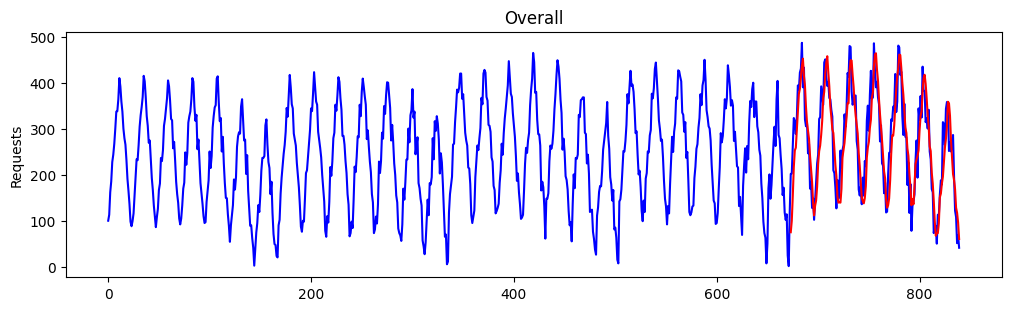

In [70]:
fig, ax = plt.subplots( figsize = (10,3), constrained_layout=True)
sns.lineplot(x=range(len(df)),y=df['Requests'][:(len(df))],color='blue', legend='auto')
sns.lineplot(x=range(len(df)-len(predict_on_test), len(df)),y=predict_on_test[:,0],color='red')
ax.set_title('Overall')